# Лабораторная работа №7

# Импортируем необходимые библиотеки

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import mplcyberpunk
from sympy import *

## Выставим стиль для графиков

In [2]:
plt.style.use("cyberpunk")

# 1) Реализуем метод стрельбы для решения краевой задачи ДУ 2-го порядка
$$ \cases{y'' - \frac{0.5}{1-0.5y} (y')^2 = 0\\ y(0) = [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95] \\ y(1) = 0 \\ 0 < x \le 1}$$

In [3]:
def Runge_Kutta4 (Func, initialT, initialСondition, numOfIterations, h):
    solution = [initialСondition]
    t = initialT
    
    for i in range(numOfIterations):
        k1 = Func(t, solution[-1])
        k2 = Func(t + h / 2, solution[-1] + h / 2 * k1)
        k3 = Func(t + h / 2, solution[-1] + h / 2 * k2)
        k4 = Func(t + h, solution[-1] + h * k3)
        t += h
        solution.append(solution[-1] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
        
    return solution

def Shooting (Func, firstCond, secondCond, step = 0.001, accuracy=0.001):
    xFirst, yFirst = firstCond
    xSecond, ySecond = secondCond

    lessParam = float('NaN')
    greaterParam = float('NaN')
    
    numParams = 50
    param = np.linspace(-1, 1, numParams)
    idx = 0
    solution = []

    while (math.isnan(lessParam) or math.isnan(greaterParam)):
        solution = Runge_Kutta4(Func, xFirst, np.array([yFirst, param[idx]]), int((xSecond - xFirst) / step), step)
        solYsecond = solution[-1][0]
        if (solYsecond < ySecond):
            lessParam = param[idx]
        if (solYsecond > ySecond):
            greaterParam = param[idx]
        idx += 1
        if (idx >= numParams):
            break

    while (abs(ySecond - solution[-1][0]) >= accuracy):
        middleParam = (greaterParam + lessParam) / 2
        solution = Runge_Kutta4(Func, xFirst, np.array([yFirst, middleParam]), int((xSecond - xFirst) / step), step)
        solYsecond = solution[-1][0]
        if (solYsecond < ySecond):
            lessParam = middleParam
        if (solYsecond > ySecond):
            greaterParam = middleParam

    return solution

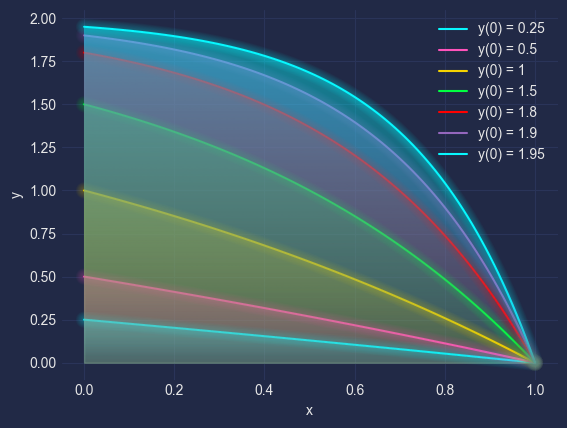

In [4]:
var('x, y, u')
f =  Array([u, -0.5 / (1 - 0.5 * y) * (u**2)])
func = lambdify((x,[y,u]), f, 'numpy')

initCond = [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95]
for i in initCond:
    step = 0.01
    points = Shooting(func, [0, i], [1, 0], step)
    plt.plot(np.linspace(0, 1, int(1 / step) + 1), [item[0] for item in points], label=f"y(0) = {i}")
    plt.xlabel('x')
    plt.ylabel('y')

plt.legend()
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)
plt.show()

# 2) Реализуем решение линейной краевой задачи методом прогонки

# Уравнение теплопроводности с дополнительными условиями
$$ \cases{\frac{\partial}{\partial x} \left[ k(x) \frac{\partial U}{\partial x}\right] - q(x) U = - f(x) \\ U(0) = 1; U(1) = 0 \\ U(x_0 - 0) = U(x_0 + 0) \\
k(x_0 - 0) U_x (x_0 - 0) = k(x_0 + 0) U_x (x_0 + 0) \\ x < x_0 = \frac{1}{\sqrt{2}} \Rightarrow \cases {k(x) = e^{-x}\\ q(x) = x^2\\ f(x) = 1} \\ 
x > x_0 = \frac{1}{\sqrt{2}} \Rightarrow \cases {k(x) = 1\\ q(x) = e^{-x^2}\\ f(x) = \cos x}}$$

### Зададим функции $k(x)$, $q(x)$, $f(x)$:

In [5]:
def k(x, x_0):
    if (x < x_0):
        return np.exp(-x)
    else:
        return 1

def q(x, x_0):
    if (x < x_0):
        return x ** 2
    else:
        return np.exp(-(x ** 2))

def f(x, x_0):
    if (x < x_0):
        return 1
    else:
        return np.cos(x)


# Функция для заполнения коэффициентов

In [6]:
def get_coeffs(step, N, x_0, leftBorder):
    a = np.zeros(N + 1)
    b = np.zeros(N + 1)
    c = np.zeros(N + 1)
    d = np.zeros(N + 1)

    rightBorder= leftBorder + 1

    for i in range(1, N):
        a[i] = k((i + 0.5) * step, x_0)
        b[i] = -(k((i + 0.5) * step, x_0) + k((i - 0.5) * step, x_0) + q(i * step, x_0) * step ** 2)
        c[i] = k((i - 0.5) * step, x_0)
        d[i] = -f(i * step, x_0) * step ** 2

    for i in range(leftBorder, rightBorder + 1):
        a[i] = 0
        b[i] = 0
        c[i] = 0
        d[i] = 0

    return a, b, c, d

def progonka(leftCond, rightCond, x_0, step = 0.01):
    xLeft, uLeft = leftCond
    xRight, uRight = rightCond
    
    N = int((xRight - xLeft) / step)
    
    leftBorder = int(np.floor((x_0 - xLeft) / step))
    
    a, b, c, d = get_coeffs(step, N, x_0, leftBorder)
    
    alpha = np.zeros(N + 1)
    beta  = np.zeros(N + 1)
    u = np.zeros(N + 1)
    u[0] = uLeft
    u[N] = uRight

    alpha[1] = -a[1] / b[1]
    beta[1]  = (d[1] - c[1] * uLeft) / b[1]

    alpha[N - 1] = -c[N - 1] / b[N - 1]
    beta[N - 1]  = (d[N - 1] - c[N - 1] * uRight) / b[N - 1]
    
    for i in range(2, leftBorder):
        alpha[i] = -a[i] / (b[i] + c[i] * alpha[i - 1])
        beta[i]  = (d[i] - c[i] * beta[i - 1]) / (b[i] + c[i] * alpha[i - 1])
    
    for i in range(N - 2, leftBorder + 1, -1):
        alpha[i] = -c[i] / (b[i] + a[i] * alpha[i + 1])
        beta[i]  = (d[i] - a[i] * beta[i + 1]) / (b[i] + a[i] * alpha[i + 1])
    
    u[leftBorder] = (k(leftBorder * step, x_0) * beta[leftBorder - 1] + k((leftBorder + 1) * step, x_0) * beta[leftBorder + 2]) / \
                                     (k(leftBorder * step, x_0) * (1 - alpha[leftBorder - 1]) + k((leftBorder + 1) * step, x_0) * (1 - alpha[leftBorder + 2]))
    u[leftBorder + 1] = u[leftBorder].copy()
    u[leftBorder - 1] = alpha[leftBorder - 1] * u[leftBorder] + beta[leftBorder - 1]
    u[leftBorder + 2] = alpha[leftBorder + 2] * u[(leftBorder + 1)] + beta[leftBorder + 2]

    for i in range(leftBorder - 1, 0, -1):
        u[i] = alpha[i] * u[i + 1] + beta[i]

    for i in range(leftBorder + 2, N):
        u[i] = alpha[i] * u[i - 1] + beta[i]

    return u

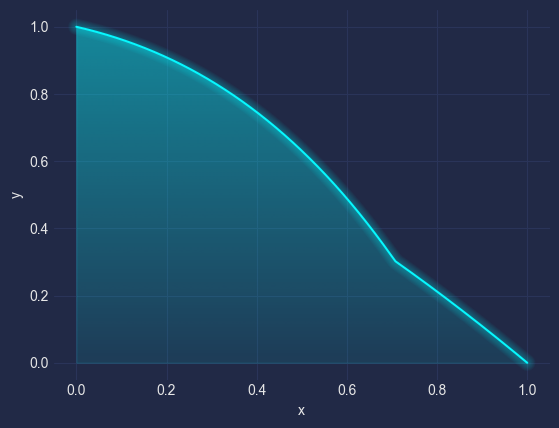

In [7]:
step_ = 0.0001
border = 1/np.sqrt(2)
result = progonka([0, 1], [1, 0], border, step_)

plt.plot(np.arange(0, 1 + step_, step_), result)
plt.xlabel('x')
plt.ylabel('y')
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)